In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize
from rouge import Rouge
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import log_loss, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score, roc_auc_score
from malnis import show

/home/jarobyte/envs/malnis/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
data_folder = "/home/jarobyte/scratch/malnis_dataset/data/"

In [3]:
train = pd.read_pickle(data_folder + "data_train.pkl")
show(train)

(7172, 9)


,query,document,summary,r1,r2,rl,sentences,relevance,original_sentences
7593,Due to the lack of structured knowledge applie...,"Index Terms—Machine learning, knowledge discov...","[Text classification [226], text clustering [2...",0.278846,0.095941,0.259615,"[Index Terms—Machine learning, knowledge disco...","[False, False, False, False, False, False, Fal...",685
7554,Obtaining enough labeled data to robustly trai...,One of the greatest roadblocks to using modern...,"[“Lawyer”); moreover, these sources might be c...",0.295455,0.104247,0.272727,[One of the greatest roadblocks to using moder...,"[True, False, True, False, False, False, False...",246
4892,"Word embeddings, i.e., low-dimensional vector ...",Recently some studies have shown that text cla...,"[A recent work (Schuster et al., 2020) showed ...",0.407018,0.186364,0.385965,[Recently some studies have shown that text cl...,"[False, False, True, False, False, False, Fals...",202
4169,"In this paper our objectives are, first, netwo...",It is commonsense that how you look at an obje...,"[Views are commonly different sensory signals,...",0.257143,0.090909,0.250000,[It is commonsense that how you look at an obj...,"[False, False, False, False, False, False, Fal...",240
6690,"This paper describes TextTiling, an algorithm ...",Accurately representing the distance between t...,[Most similar to our method is that of Wan (20...,0.206349,0.037975,0.158730,[Accurately representing the distance between ...,"[False, False, False, False, False, False, Fal...",246


In [4]:
dev = pd.read_pickle(data_folder + "data_dev.pkl")
show(dev)

(896, 9)


,query,document,summary,r1,r2,rl,sentences,relevance,original_sentences
5367,We propose the task of free-form and open-ende...,"Index Terms—Deep learning, visual analytics, i...",[Research combining both image and text data h...,0.249240,0.117400,0.218845,"[Index Terms—Deep learning, visual analytics, ...","[False, False, False, False, True, False, Fals...",497
4278,"In this paper, we propose a novel neural netwo...",Document summarization aims to produce fluent ...,"[For each sentence, we apply an RNN with Gated...",0.281407,0.112281,0.281407,[Document summarization aims to produce fluent...,"[False, False, False, False, False, False, Fal...",238
307,Learning to rank with biased click data is a w...,CCS CONCEPTS • Information systems→ Learning t...,"[Most recently, a new approach for de-biasing ...",0.321716,0.160558,0.289544,[CCS CONCEPTS • Information systems→ Learning ...,"[True, False, False, False, False, False, Fals...",401
4413,"We present the Compressive Transformer, an att...","Transformers (Vaswani et al., 2017) have achie...",[on this task as their primary evaluation (Dai...,0.254144,0.075314,0.232044,"[Transformers (Vaswani et al., 2017) have achi...","[False, False, False, False, False, False, Fal...",357
2963,We propose a method for online news stream clu...,ACM Reference Format: Doug Beeferman and Hang ...,[[17] is the first to include BERT contextual ...,0.255102,0.094203,0.255102,[ACM Reference Format: Doug Beeferman and Hang...,"[False, False, False, False, False, False, Fal...",185


In [5]:
true_targets = np.concatenate(dev.relevance.to_list())
print("true targets", true_targets.shape)

true targets (264918,)


In [6]:
records = dev.to_dict("records")
len(records)

896

In [7]:
output_folder = "/home/jarobyte/scratch/malnis_dataset/data/classical_models/"

# TFIDF

In [8]:
%%time

predictions = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer()
    sentences = d["sentences"]
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevance = (query_emb @ features.T).toarray().squeeze()
#     print(relevance.shape)
    predictions.append(relevance)

true_predictions = np.concatenate(predictions)
print("true predictions", true_predictions.shape)

np.save(output_folder + "tfidf_words.npy", true_predictions)

# fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# display = PrecisionRecallDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Words",
#     ax = axes[0]
# )

# display = RocCurveDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Words",
#     ax = axes[1]
# )

  0%|          | 0/896 [00:00<?, ?it/s]

true predictions (264918,)
CPU times: user 7.21 s, sys: 0 ns, total: 7.21 s
Wall time: 7.43 s


In [9]:
%%time

#chars

predictions = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer(
        analyzer = "char",
        ngram_range = (3, 3)
    )    
    sentences = d["sentences"]
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevance = (query_emb @ features.T).toarray().squeeze()
#     print(relevance.shape)
    predictions.append(relevance)

true_predictions = np.concatenate(predictions)
print("true predictions", true_predictions.shape)

np.save(output_folder + "tfidf_chars.npy", true_predictions)

# fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# display = PrecisionRecallDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Chars",
#     ax = axes[0]
# )

# display = RocCurveDisplay.from_predictions(
#     true_targets, true_predictions, name = "TFIDF Chars",
#     ax = axes[1]
# )

  0%|          | 0/896 [00:00<?, ?it/s]

true predictions (264918,)
CPU times: user 23.5 s, sys: 52.1 ms, total: 23.6 s
Wall time: 24.2 s


# Sentence-BERT

In [10]:
X_dev = np.load(data_folder + "embeddings/sbert/X_dev.npy")
X_dev.shape

(896, 512, 768)

In [11]:
Y_dev = np.load(data_folder + "embeddings/sbert/Y_dev.npy")
Y_dev.shape

(896, 512)

In [12]:
queries = X_dev[:, :, :384]
queries.shape

(896, 512, 384)

In [13]:
sentences = X_dev[:, :, 384:]
sentences.shape

(896, 512, 384)

In [14]:
product = (queries * sentences).sum(-1)
product.shape

(896, 512)

In [15]:
product.min(), product.max()

(-0.20736787, 0.8849211)

In [16]:
product[product < 0] = 0

product.min(), product.max()

(0.0, 0.8849211)

In [17]:
true_predictions = np.concatenate([p[:l] for l, p in zip(tqdm(dev.original_sentences), product)])
true_predictions.shape

  0%|          | 0/896 [00:00<?, ?it/s]

(264918,)

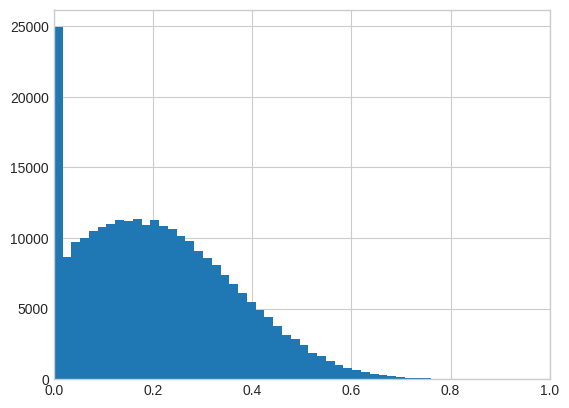

In [18]:
plt.hist(
    true_predictions,
    bins = 50
)
plt.xlim(0, 1)
plt.show()

In [19]:
np.save(output_folder + "sbert.npy", true_predictions)

In [20]:
targets = np.concatenate(dev.relevance.to_list())
print("targets", targets.shape)

targets (264918,)


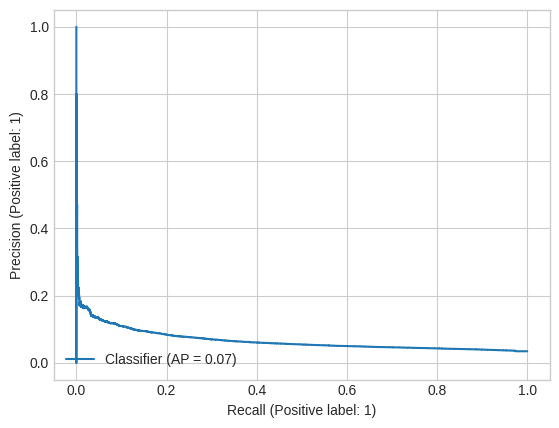

In [21]:
PrecisionRecallDisplay.from_predictions(targets, true_predictions)
plt.show()

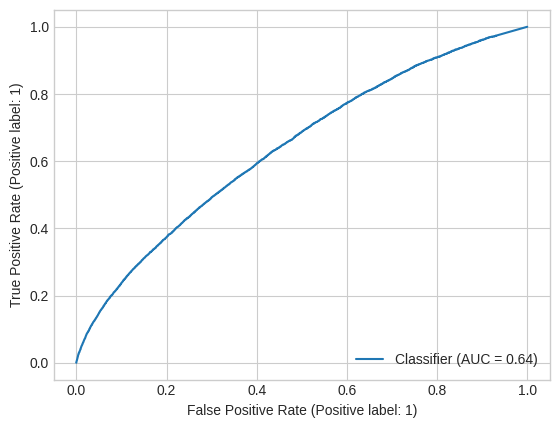

In [22]:
RocCurveDisplay.from_predictions(targets, true_predictions)
plt.show()

# SPECTER

In [23]:
X_dev = np.load(data_folder + "embeddings/specter/X_dev.npy")
X_dev.shape

(896, 512, 1536)

In [24]:
Y_dev = np.load(data_folder + "embeddings/specter/Y_dev.npy")
Y_dev.shape

(896, 512)

In [25]:
queries = X_dev[:, :, :768]
queries.shape

(896, 512, 768)

In [26]:
sentences = X_dev[:, :, 768:]
sentences.shape

(896, 512, 768)

In [27]:
distances = ((queries - sentences) ** 2).sum(-1)
distances.shape

(896, 512)

In [28]:
distances.min(), distances.mean(), distances.max()

(0.0, 142.18779, 694.8766)

  0%|          | 0/896 [00:00<?, ?it/s]

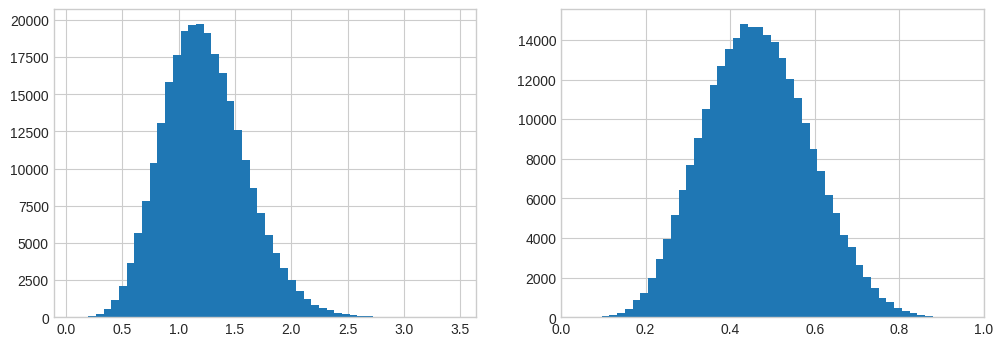

In [29]:
unpadded_distances = np.concatenate([p[:l] for l, p in zip(tqdm(dev.original_sentences), distances)])
unpadded_distances = unpadded_distances / 200

# true_predictions = 1 / (1 + (10**-3) * unpadded_distances)
# true_predictions = 1 / (1 + (10**-2.5) * unpadded_distances)
true_predictions = 2 / (1 + np.exp(unpadded_distances))

# true_predictions.shape

f, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(unpadded_distances, bins = 50)
axes[1].hist(true_predictions, bins = 50)
axes[1].set_xlim(0, 1)
plt.show()

In [30]:
true_predictions

array([0.38911125, 0.40271607, 0.38083205, ..., 0.39817068, 0.3027502 ,
       0.48780653], dtype=float32)

In [31]:
2 / (1 + np.exp(unpadded_distances / 2000))

array([0.9996449 , 0.9996556 , 0.9996382 , ..., 0.999652  , 0.9995691 ,
       0.99971706], dtype=float32)

# $\frac{1}{\beta + \alpha x}$

In [32]:
alpha = np.linspace(0.1, 3, 30)
beta = np.linspace(0.5, 5, 40)

In [33]:
predictions = 1 / (beta.reshape(-1, 1, 1) + alpha.reshape(-1, 1) * unpadded_distances)
predictions.shape

(40, 30, 264918)

In [34]:
scores = [average_precision_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/40 [00:00<?, ?it/s]

count    1.200000e+03
mean     5.053350e-02
std      1.388357e-17
min      5.053350e-02
25%      5.053350e-02
50%      5.053350e-02
75%      5.053350e-02
max      5.053350e-02
dtype: float64

In [35]:
scores = [roc_auc_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/40 [00:00<?, ?it/s]

count    1200.000000
mean        0.584287
std         0.000000
min         0.584287
25%         0.584287
50%         0.584287
75%         0.584287
max         0.584287
dtype: float64

# $\frac{2}{1 + e ^ {a + b x}}$

In [46]:
A = np.linspace(0.1, 10, 12)
B = np.linspace(0.1, 10, 13)
# C = np.linspace(0.1, 10, 14)

In [52]:
predictions = 2 / (1 + np.exp((B.reshape(-1, 1, 1) + A.reshape(-1, 1) * unpadded_distances)))
predictions.shape

(13, 12, 264918)

In [53]:
predictions.min(), predictions.mean(), np.median(predictions), predictions.max()

(7.39659875571076e-20,
 0.021698481129944394,
 3.6168194278146844e-05,
 0.9470506075938715)

In [54]:
scores = [average_precision_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/13 [00:00<?, ?it/s]

count    1.560000e+02
mean     5.053350e-02
std      2.088372e-17
min      5.053350e-02
25%      5.053350e-02
50%      5.053350e-02
75%      5.053350e-02
max      5.053350e-02
dtype: float64

In [55]:
scores = [roc_auc_score(targets, a) for b in tqdm(predictions) for a in b]
scores = pd.Series(scores)
scores.describe()

  0%|          | 0/13 [00:00<?, ?it/s]

count    1.560000e+02
mean     5.842875e-01
std      1.113799e-16
min      5.842875e-01
25%      5.842875e-01
50%      5.842875e-01
75%      5.842875e-01
max      5.842875e-01
dtype: float64

# plots

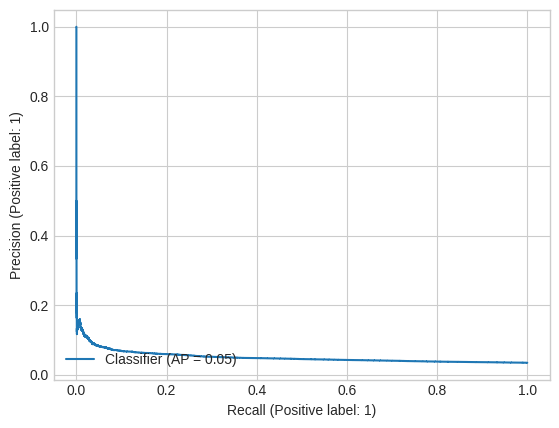

In [41]:
PrecisionRecallDisplay.from_predictions(targets, true_predictions)
plt.show()

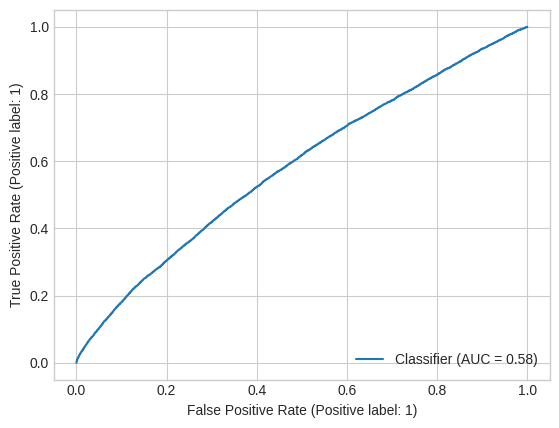

In [42]:
RocCurveDisplay.from_predictions(targets, true_predictions)
plt.show()

In [43]:
np.save(output_folder + "specter.npy", true_predictions)